# <font color='red'>
---
### <center> <font color='red'> Masters in Mathematical Finance
##### <center> <font color='red'> 2025 / 26
# <center> <font color='red'> Lévy Processes and Applications
---
### <center> <font color='red'><font> Group **CGMY**:</font>
##### <center> <font color='red'><font> António Mendonça, l58028 </font>
##### <center> <font color='red'><font> Julians Mošenko-Galuzo, l65548 </font>
##### <center> <font color='red'><font> Petr Terletskiy, l63023 </font>
##### <center> <font color='red'><font> Thomas Nava, l65640 </font>
##### <center> <font color='red'><font> Tiago Monteiro, l63044 </font>

---
### <center> <font color='red'><font> Group Project: Analysis and Application of the CGMY Model for SPX Option Pricing </font>
---


# **Introduction**

### **Beyond Black-Scholes: Capturing the Fine Structure of Asset Returns**

The **CGMY model** (named after Carr, Geman, Madan, and Yor) represents a significant advancement in financial modeling by addressing key limitations of traditional models like Black-Scholes.

While Black-Scholes assumes asset prices follow a continuous geometric Brownian motion with constant volatility, real financial markets exhibit:

- **Jumps and discontinuities** in price paths
- **Fat tails** (extreme events occur more frequently than predicted by normal distribution)
- **Volatility smiles/skews** in option prices
- **High-frequency small movements** that accumulate over time

The CGMY model belongs to the family of **Lévy processes** - stochastic processes with stationary and independent increments that can capture these realistic features.

### **What Makes CGMY Special?**

The CGMY model generalizes the popular **Variance Gamma (VG)** process by introducing a crucial parameter `Y` that controls the **fine structure** of the process:

- **Activity**: How many jumps occur (finite vs infinite)
- **Variation**: How "rough" the price paths are (finite vs infinite variation)

#### **Parameter Interpretation:**

- **`C`**: Overall activity rate (higher = more jumps)
- **`G`**: Decay rate for downward jumps (higher = fewer large crashes)
- **`M`**: Decay rate for upward jumps (higher = fewer large rallies)  
- **`Y`**: Fine structure parameter (determines activity and variation)


#### **The Magic of Parameter `Y`:**
- **`Y < 0`**: Finite activity (finite number of jumps)
- **`0 < Y < 1`**: Infinite activity, finite variation
- **`1 < Y < 2`**: Infinite activity, infinite variation

When `Y = 0`, the CGMY model reduces to the familiar **Variance Gamma** process.

This flexibility allows the CGMY model to capture everything from rare large jumps to the "infinite shower" of small price movements observed in high-frequency data, making it particularly powerful for modeling modern financial markets.


### **CGMY Model Parameters**

<br>

| Model | **C** | **G** | **M** | **Y** |
|:------|:-----:|:-----:|:-----:|:-----:|
| CGMY  | 0.0244 | 0.0765 | 7.5515 | 1.2945 |

<br>

**Source and Context**:
- _These parameters were estimated for the CGMY model, a mean-correcting Lévy process, and are reproduced from **Table 6.3** of the book: **Lévy Processes in Finance: Pricing Financial Derivatives** by **Wim Schoutens**._

In [ ]:
# CGMY parameters
CGMY_params = {
    'C': 0.0244,
    'G': 0.0765,
    'M': 7.5515,
    'Y': 1.2945}

print("CGMY Parameters from Schoutens (2003), Table 6.3:")
print(f"- C = {CGMY_params['C']:.4f}")
print(f"- G = {CGMY_params['G']:.4f}")
print(f"- M = {CGMY_params['M']:.4f}")
print(f"- Y = {CGMY_params['Y']:.4f}")

# Analyze the fine structure based on Y parameter
print("\nFine Structure Analysis (Carr et al., 2002):")
if CGMY_params['Y'] > 1:
    print(f"Y = {CGMY_params['Y']:.4f} > 1: Infinite Activity, Infinite Variation Process")
    print("  - Completely monotone Lévy density")
    print("  - Infinite variation (rough paths)")
    print("  - Finite quadratic variation")
elif CGMY_params['Y'] > 0:
    print(f"Y = {CGMY_params['Y']:.4f} > 0: Infinite Activity, Finite Variation Process")
else:
    print(f"Y = {CGMY_params['Y']:.4f}: Finite Activity Process")


CGMY Parameters from Schoutens (2003), Table 6.3:
- C = 0.0244
- G = 0.0765
- M = 7.5515
- Y = 1.2945

Fine Structure Analysis (Carr et al., 2002):
Y = 1.2945 > 1: Infinite Activity, Infinite Variation Process
  - Completely monotone Lévy density
  - Infinite variation (rough paths)
  - Finite quadratic variation


# Dependencies

In [ ]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import integrate
from scipy.special import gamma
from scipy.integrate import quad
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

# Random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Display options
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

print("Libraries imported and configuration applied successfully! ✅")

Libraries imported and configuration applied successfully! ✅


# **Part 1 - Simulation and Parameter Analysis of the CGMY Lévy Process**

Simulate some trajectories of the underlying Lévy process of your
model and plot these trajectories for the parameter values estimated in the
book and also for a set of different values of the parameters, in order to
analyse the effect of the parameters on the trajectories.

Describe the algorithm you use for the simulation of these trajectories. About the simulation of Lévy processes, we recommend as main sources of
information the chapter 8 of Schoutens book and/or chapter 6 of the book
of Cont and Tankov.

### **1.1 - Lévy Density Functions**


These define the **jump intensity measure** ν(dx):

- **`nu_pos`**: Intensity of positive jumps (x > 0)

- **`nu_neg`**: Intensity of negative jumps (x < 0)

- **`C`**: Overall activity rate (higher = more jumps)
- **`G`**: Decay rate for downward jumps (higher = fewer large crashes)
- **`M`**: Decay rate for upward jumps (higher = fewer large rallies)  
- **`Y`**: Fine structure parameter (determines activity and variation)

In [ ]:
def nu_pos(x, C, M, Y):  #with x > 0
    return C * np.exp(-M*x) / (x**(1.0 + Y))

def nu_neg(x, C, G, Y):  #with x < 0
    return C * np.exp(G*x) / ((-x)**(1.0 + Y))

### **1.2 - Small Jump Moments Calculation**


- Computes **`mean(m)`** and **`variance(v)`** of small jumps **(|x| ≤ ε)** via Lévy density integration

- Quantifies drift and volatility from infinitesimal jumps

- Uses **Central Limit Theorem** to approximate cumulative effect as Gaussian noise

- Adds realistic continuous fluctuations between large jumps

- Prevents unnatural piecewise-flat trajectories

In [ ]:
def cgmy_smalljump_moments(eps, C, G, M, Y):
    """Return small-jump mean and variance on (-eps, eps)."""
    #for calculating the mean
    m_pos, _ = quad(lambda x: x*nu_pos(x, C, M, Y), 0.0, eps, limit=200)
    m_neg, _ = quad(lambda x: x*nu_neg(x, C, G, Y), -eps, 0.0, limit=200)
    m = m_pos + m_neg

    # for calculating the variance
    v_pos, _ = quad(lambda x: (x*x)*nu_pos(x, C, M, Y), 0.0, eps, limit=200)
    v_neg, _ = quad(lambda x: (x*x)*nu_neg(x, C, G, Y), -eps, 0.0, limit=200)
    v = v_pos + v_neg
    return m, v

### **1.3 - Big Jump Rates Calculation**

For Large Jumps (|x| > ε):

- Uses Poisson process to model random timing of large jumps

- Simulates jump timing via Poisson process

- Financially represents unexpected market shocks and news events

- `lam_pos`: Rate of positive large jumps per unit time

- `lam_neg`: Rate of negative large jumps per unit time

In [ ]:
def cgmy_bigjump_rates(eps, C, G, M, Y):
    """Return intensities for big positive/negative jumps (|x|>eps)."""
    lam_pos, _ = quad(lambda x: nu_pos(x, C, M, Y), eps, np.inf, limit=200)
    lam_neg, _ = quad(lambda x: nu_neg(x, C, G, Y), -np.inf, -eps, limit=200)
    return lam_pos, lam_neg

### **1.4 - Large Jump Sampling**

- **Sums all large jumps (|x| > ε) per time step**

- **Input: N** (Poisson count of jumps from `rng.poisson`)

- **Jump size = ε + Exponential(1/temper)** where:

  - **temper = M** for positive jumps, G for negative jumps

  - Controls Lévy tail decay

- **sign = +1/-1** sets jump direction

- **Output:** Total jump contribution for the time step

- **Creates visible price** spikes in paths

- **Exponential sampling** ensures computational efficiency


**Key variables:**

`N` = number of jumps (from Poisson)

`ε` = minimum jump size threshold

`temper` = M (up) or G (down) - tail decay parameter

`sign` = direction (+1/-1)

`jumps` = ε + Exp(1/temper) - individual jump sizes



In [ ]:
def sample_tail_sum_poisson(N, rate, eps, temper, sign, rng):
    """
    Sum of N exponentials shifted by eps: J = sum_{k=1}^N (eps + Exp(temper)).
    sign = +1 for positive jumps, -1 for negative jumps.
    """
    if np.isscalar(N):
        N = np.array([N], dtype=int)
    out = np.zeros_like(N, dtype=float)
    idx = np.where(N > 0)[0]
    for i in idx:
        m = int(N[i])
        # Exponential tail proposal: good for tempered power-law tails
        jumps = rng.exponential(1.0/temper, size=m) + eps
        out[i] = sign * np.sum(jumps)
    return out

### **1.5 - Main Path Simulation**

**Key steps in the simulation loop:**

**1) Calculate per-time-step parameters:**

  - `mu_step`: Compensation term (centers the process)

  - `sigma_step`: Standard deviation for small jump Gaussian approximation

  - `lam_pos_dt`, `lam_neg_dt`: Probabilities of large jumps in each time step

**2) For each time step:**

  - `dW`: Gaussian noise representing small jumps

  - `Np`, `Nn`: Number of large positive/negative jumps (Poisson)

  - `Jp`, `Jn`: Sizes of large jumps

  - `dX`: Total increment = compensation + small jumps + large jumps

In [ ]:
def simulate_cgmy_paths(T=1.0, n_steps=500, n_paths=10, C=0.0244, G=0.0765, M=7.5515, Y=1.2945,
                        eps=1e-3, seed=42):
    """
    Simulate CGMY Lévy process paths X_t using:
      - compound Poisson for |x|>eps
      - Gaussian approx for sum of |x|<=eps (mean m_sj, var v_sj)
    Returns times (t), array X of shape (n_paths, n_steps+1)
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps

    # small-jump mean and variance per unit time
    m_sj, v_sj = cgmy_smalljump_moments(eps, C, G, M, Y)
    # big-jump intensities per unit time
    lam_pos, lam_neg = cgmy_bigjump_rates(eps, C, G, M, Y)

    # per-step parameters
    mu_step     = -m_sj * dt              # mean correction (center increments)
    sigma_step  = np.sqrt(v_sj * dt)      # Gaussian sigma for small jumps
    lam_pos_dt  = lam_pos * dt
    lam_neg_dt  = lam_neg * dt

    X = np.zeros((n_paths, n_steps+1))
    for k in range(1, n_steps+1):
        # Gaussian small-jump component
        dW = rng.normal(loc=0.0, scale=sigma_step, size=n_paths)

        # Big-jumps (compound Poisson)
        Np = rng.poisson(lam_pos_dt, size=n_paths)
        Nn = rng.poisson(lam_neg_dt, size=n_paths)
        Jp = sample_tail_sum_poisson(Np, lam_pos_dt, eps, temper=M, sign=+1, rng=rng)
        Jn = sample_tail_sum_poisson(Nn, lam_neg_dt, eps, temper=G, sign=-1, rng=rng)

        dX = mu_step + dW + Jp + Jn
        X[:, k] = X[:, k-1] + dX

    t = np.linspace(0, T, n_steps+1)
    return t, X

### **1.6 - Base Case Plots**

- Shows 8 simulated CGMY paths using Schoutens' base parameters.

- Combines continuous small-jump noise and discrete big jumps.

- Downward jumps are more frequent and larger → left-skewed paths (since G < M).

- Parameter `Y>1`:
    - Y>1 ⇒ infinite variation → very rough and irregular trajectories.

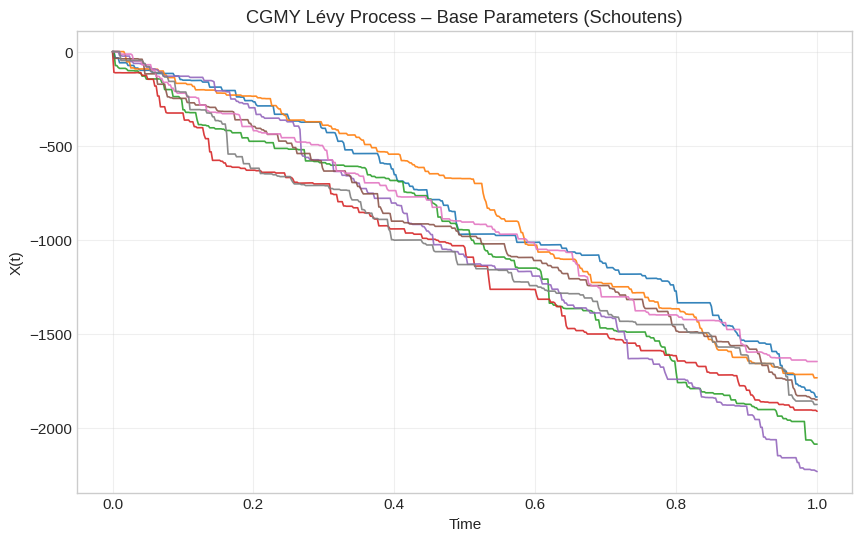

In [ ]:
C0, G0, M0, Y0 = 0.0244, 0.0765, 7.5515, 1.2945
t, X = simulate_cgmy_paths(T=1.0, n_steps=500, n_paths=8, C=C0, G=G0, M=M0, Y=Y0, eps=1e-3, seed=1)

plt.figure(figsize=(10,6))
for i in range(X.shape[0]):
    plt.plot(t, X[i], lw=1.2, alpha=0.9)
plt.title("CGMY Lévy Process – Base Parameters (Schoutens)")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.show()

### **1.7 - SENSITIVITY: Vary C (+50%)**

- Here we increase parameter C, which controls overall jump **activity rate**.

- The paths **show more frequent jumps** (looks busier) while maintaining the same skewness.

- This demonstrates that higher C intensifies both upward and downward movements.

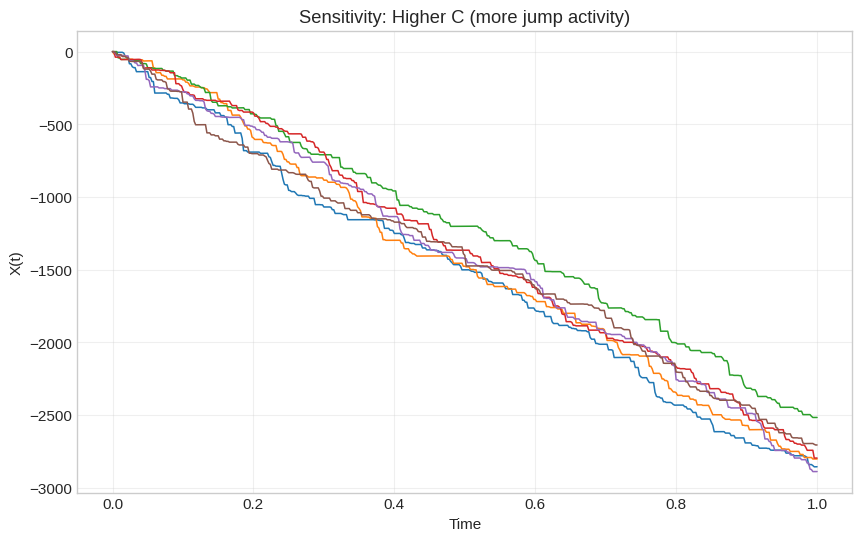

In [ ]:
t, X_hiC = simulate_cgmy_paths(C=1.5*C0, G=G0, M=M0, Y=Y0, seed=2)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.plot(t, X_hiC[i], lw=1.1)
plt.title("Sensitivity: Higher C (more jump activity)")
plt.xlabel("Time"); plt.ylabel("X(t)"); plt.grid(True, alpha=0.3); plt.show()


### **1.8 - SENSITIVITY: Asymmetry (swap G and M)**

- Swapped **G** and **M**, flipping the asymmetry of the Lévy density.

- Results in **heavier right tail**, there fore this results in more/larger **positive jumps** than negative ones.

- Paths exhibit stronger upward spikes and fewer large crashes.

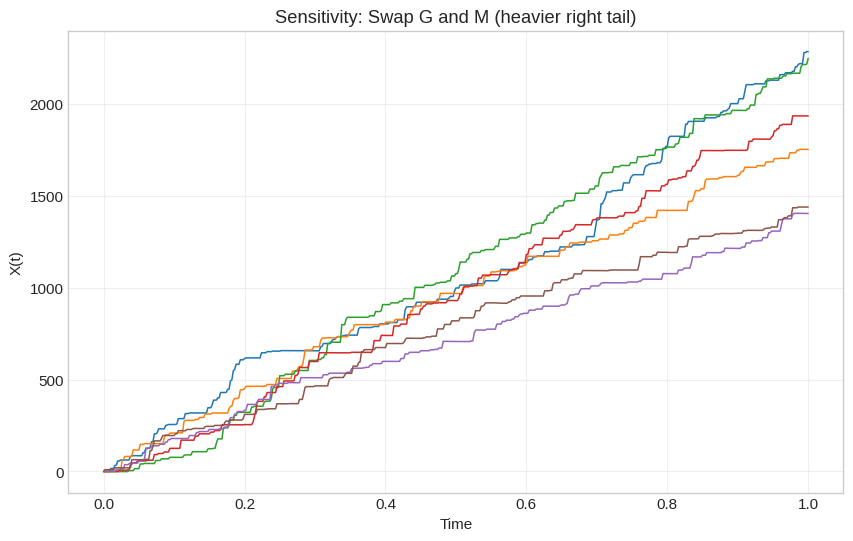

In [ ]:
t, X_swap = simulate_cgmy_paths(C=C0, G=M0, M=G0, Y=Y0, seed=3)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.plot(t, X_swap[i], lw=1.1)
plt.title("Sensitivity: Swap G and M (heavier right tail)")
plt.xlabel("Time"); plt.ylabel("X(t)"); plt.grid(True, alpha=0.3); plt.show()

### **1.9 - SENSITIVITY: Vary Y (0.3, 0.7, 1.3)**

**Y Parameter Analysis**:

- Sensitivity: **Y = 0.3**:

    - The process has **finite activity and finite variation**, so only a few jumps occur.

    - Paths are mostly flat, interrupted by **rare large jumps**.

    - Each jump moves sharply downward (since G < M, implying a heavier left tail).

    - Visually resembles a **compound Poisson process** which is isolated, discrete jumps, and not continuous noise.

- Sensitivity: **Y = 0.7**:

   - The process has **infinite activity but finite variation**.

    - Paths show **more frequent jumps** of varying sizes, still clearly discontinuous.

    - Many moderate-sized downward jumps that accumulate over time.
- Sensitivity: **Y = 1.3**:

    - The process has **infinite activity** and **infinite variation**.

    - Paths exhibit **many small and medium jumps**, creating a **rough, continuous-like trajectory**.

    - The accumulated effect of countless tiny jumps leads to a steep, jagged downward drift.

    - Visually closer to a **Lévy process with Brownian-like roughness**.


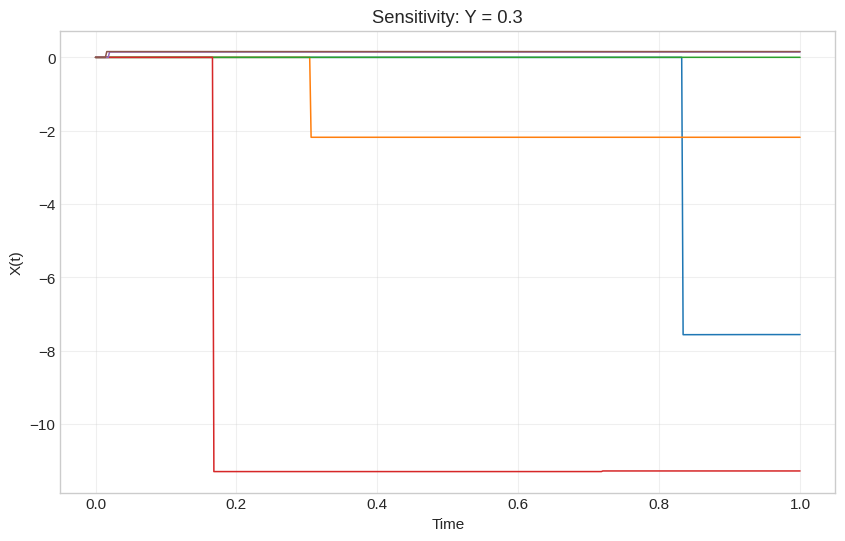

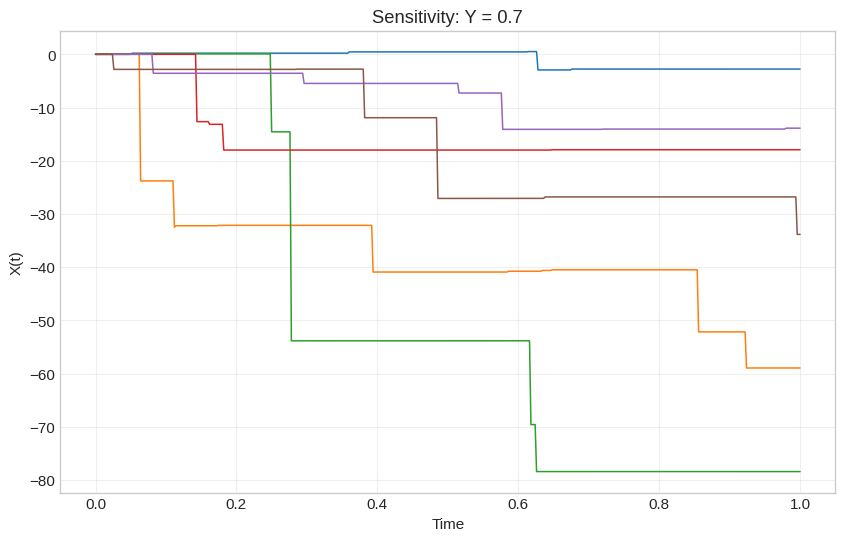

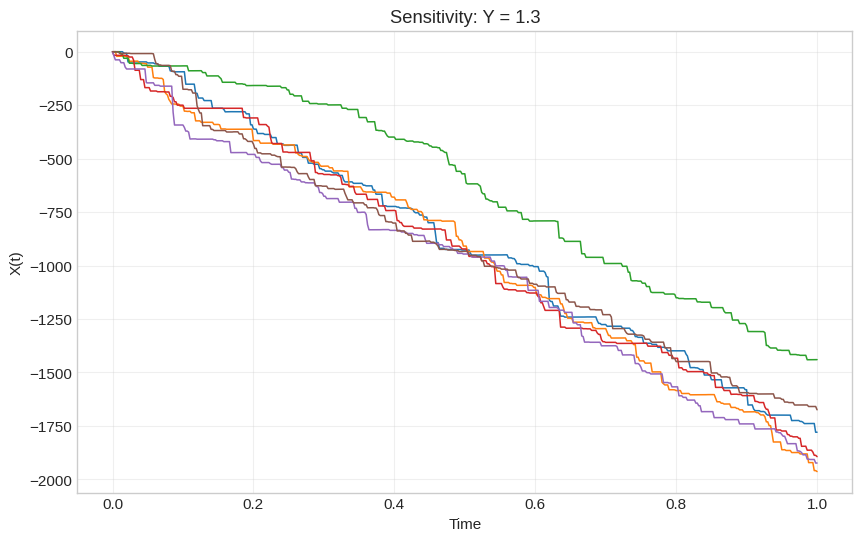

In [ ]:
for Ytest in [0.3, 0.7, 1.3]:
    t, X_Y = simulate_cgmy_paths(C=C0, G=G0, M=M0, Y=Ytest, seed=10+int(10*Ytest))
    plt.figure(figsize=(10,6))
    for i in range(6):
        plt.plot(t, X_Y[i], lw=1.1)
    plt.title(f"Sensitivity: Y = {Ytest}")
    plt.xlabel("Time"); plt.ylabel("X(t)"); plt.grid(True, alpha=0.3); plt.show()

# **Part 2 - European Call Option Pricing and CGMY Model Validation**

#### **S&P 500 Call Option Prices**

The prices below are for call options on the S&P 500 Index at the close of the market on **18 April 2002**.

 On that day, the S&P 500 index closed at **$1124.47**. The risk-free rate was **_r_ = 1.9%** and the dividend yield was **_q_ = 1.2%** per year.

 <br>

| Strike | May 2002 | June 2002 | Sep. 2002 | Dec. 2002 | March 2003 | June 2003 | Dec. 2003 |
|:------:|:--------:|:---------:|:---------:|:---------:|:----------:|:---------:|:---------:|
| 975    |          |           | 161.60    | 173.30    |            |           |           |
| 995    |          |           | 144.80    | 157.00    |            | 182.10    |           |
| 1025   |          |           | 120.10    | 133.10    | 146.50     |           |           |
| 1050   | 84.50    | 100.70    | 114.80    |           |            | 143.00    | 171.40    |
| 1075   |          | 64.30     | 82.50     | 97.60     |            |           |           |
| 1090   | 43.10    |           |           |           |            |           |           |
| 1100   | 35.60    |           | 65.50     | 81.20     | 96.20      | 111.30    | 140.40    |
| 1110   |          | 39.50     |           |           |            |           |           |
| 1120   | 22.90    | 33.50     |           |           |            |           |           |
| 1125   | 20.20    | 30.70     | 51.00     | 66.90     | 81.70      | 97.00     |           |
| 1130   |          | 28.50     |           |           |            |           |           |
| 1135   |          | 25.60     | 45.50     |           |            |           |           |
| 1140   | 13.30    | 23.20     |           | 58.90     |            |           |           |
| 1150   |          | 19.10     | 38.10     | 53.90     | 68.30      | 83.30     | 112.80    |
| 1160   |          | 15.30     |           |           |            |           |           |
| 1170   |          | 12.10     |           |           |            |           |           |
| 1175   |          | 10.90     | 27.70     | 42.50     | 56.60      |           | 99.80     |
| 1200   |          |           | 19.60     | 33.00     | 46.10      | 60.90     |           |
| 1225   |          |           | 13.20     | 24.90     | 36.90      | 49.80     |           |
| 1250   |          |           |           | 18.30     | 29.30      | 41.20     | 66.90     |
| 1275   |          |           |           | 13.20     | 22.50      |           |           |
| 1300   |          |           |           |           | 17.20      | 27.10     | 49.50     |
| 1325   |          |           |           |           | 12.80      |           |           |
| 1350   |          |           |           |           |            | 17.10     | 35.70     |
| 1400   |          |           |           |           |            | 10.10     | 25.20     |
| 1450   |          |           |           |           |            |           | 17.60     |
| 1500   |          |           |           |           |            |           | 12.20     |

<br>

**Source and Content:**

*These call option prices on the S\&P 500 Index are reproduced from **Appendix C** (pages 155-156) of the book: **Lévy Processes in Finance: Pricing Financial Derivatives** by **Wim Schoutens**. These prices serve as the market data ('real prices') used for model calibration and error analysis in the assignment.*

In [ ]:
#########################################
# Market parameters from Schoutens book #
#########################################

S0, r, q = 1124.47, 0.019, 0.012

print("Market Parameters (Schoutens, 2003):")
print(f"- S&P 500 close on April 18, 2002 (S₀) = {S0}")
print(f"- Risk-free rate (r) = {r:.3f}")
print(f"- Dividend yield (q) = {q:.3f}")

################################
# Valuation and Maturity Dates #
################################

def third_friday(year, month):
    """Find the third Friday of a given month (standard option expiration)"""
    first_day = date(year, month, 1)
    days_until_friday = (4 - first_day.weekday()) % 7
    first_friday = first_day + timedelta(days=days_until_friday)
    third_friday = first_friday + timedelta(days=14)
    return third_friday

valuation_date = date(2002, 4, 18)
maturity_sept = third_friday(2002, 9)
maturity_dec = third_friday(2002, 12)

# Time to maturity in years (ACT/365 convention)
T_sept = (maturity_sept - valuation_date).days / 365.25
T_dec = (maturity_dec - valuation_date).days / 365.25

print("\n\nMaturity Dates:")
print(f"- September 2002: {maturity_sept} (T = {T_sept:.4f} years)")
print(f"- December 2002: {maturity_dec} (T = {T_dec:.4f} years)")

##############################
# Option data from Schoutens #
##############################

option_data = {
    'Strike': [975, 995, 1025, 1050, 1075, 1090, 1100, 1110, 1120, 1125, 1130, 1135, 1140, 1150,
               1160, 1170, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1400, 1450, 1500],
    'Sep_2002': [161.60, 144.80, 120.10, 114.80, 82.50, None, 65.50, None, None, 51.00, None, 45.50, None,
                 38.10, None, None, 27.70, 19.60, 13.20, None, None, None, None, None, None, None, None],
    'Dec_2002': [173.30, 157.00, 133.10, None, 97.60, None, 81.20, None, None, 66.90, None, None, 58.90, 53.90,
                 None, None, 42.50, 33.00, 24.90, 18.30, 13.20, None, None, None, None, None, None]
}

option_dataframe = pd.DataFrame(option_data)
df_options = option_dataframe[~(option_dataframe['Sep_2002'].isna() & option_dataframe['Dec_2002'].isna())]
df_options['Strike'] = df_options['Strike'].astype(int)
df_options['Sep_2002'] = df_options['Sep_2002'].astype(float)
df_options['Dec_2002'] = df_options['Dec_2002'].astype(float)

print("\n\nOption Data Summary (Schoutens, 2003, Appendix C):")
print(f"- Total strikes with data: {len(df_options)}")
print(f"- September 2002 options: {df_options['Sep_2002'].notna().sum()}")
print(f"- December 2002 options: {df_options['Dec_2002'].notna().sum()}")

###################
# CGMY Parameters #
###################

C, G, M, Y = CGMY_params['C'], CGMY_params['G'], CGMY_params['M'], CGMY_params['Y']

print(f"\n\nCGMY Parameters:")
print(f"- C = {C}, G = {G}, M = {M}, Y = {Y}")

Market Parameters (Schoutens, 2003):
- S&P 500 close on April 18, 2002 (S₀) = 1124.47
- Risk-free rate (r) = 0.019
- Dividend yield (q) = 0.012


Maturity Dates:
- September 2002: 2002-09-20 (T = 0.4244 years)
- December 2002: 2002-12-20 (T = 0.6735 years)


Option Data Summary (Schoutens, 2003, Appendix C):
- Total strikes with data: 15
- September 2002 options: 12
- December 2002 options: 13


CGMY Parameters:
- C = 0.0244, G = 0.0765, M = 7.5515, Y = 1.2945


### **(i) - Analytical Pricing of European Call Options (Closed-Form Formula)**

By using an appropriate closed form formula for your model (these
closed form formulas are briefly presented in page 20 of the Book of 2 Schoutens), calculate the price of some call options over the S&P 500 Index
at the close of the market on 18 April 2002. This data is presented in a
Table in Appendix C (pages 155-156) of Schoutens book.

Use the maturity dates of **September 2002** and **December 2002** and use all the strike prices in the Table for these maturity dates.


Closed-Form Formula:  `C = S₀ × exp(-qT) × Π₁ - K × exp(-rT) × Π₂`

In [ ]:
# =============================================================================
# CGMY OPTION PRICING FUNCTIONS
# =============================================================================
def cgmy_characteristic_function(u, T, S0, r, q, C, G, M, Y):
    """
    Characteristic function for CGMY model
    φ(u) = E[exp(i u log S_T)]
    """
    # Convexity correction to ensure martingale property
    gamma_negY = gamma(-Y)
    omega = -C * gamma_negY * ((M - 1)**Y - M**Y + (G + 1)**Y - G**Y)

    # Characteristic function of log stock price
    log_phi = 1j * u * (np.log(S0) + (r - q + omega) * T)
    log_phi += T * C * gamma_negY * ((M - 1j*u)**Y - M**Y + (G + 1j*u)**Y - G**Y)

    return np.exp(log_phi)

def compute_pi1_pi2(K, T, S0, r, q, C, G, M, Y, upper_limit=100):
    """
    Compute Π₁ and Π₂ using Bakshi-Madan method
    """
    k = np.log(K)  # log strike

    def pi1_integrand(u):
        if u < 1e-10:  # Handle singularity at 0
            return 0.0
        # For Π₁: use φ(u - i) / φ(-i)
        phi_minus_i = cgmy_characteristic_function(-1j, T, S0, r, q, C, G, M, Y)
        phi_u_minus_i = cgmy_characteristic_function(u - 1j, T, S0, r, q, C, G, M, Y)

        numerator = np.exp(-1j * u * k) * phi_u_minus_i
        denominator = 1j * u * phi_minus_i

        return np.real(numerator / denominator)

    def pi2_integrand(u):
        if u < 1e-10:  # Handle singularity at 0
            return 0.0
        # For Π₂: use φ(u)
        phi_u = cgmy_characteristic_function(u, T, S0, r, q, C, G, M, Y)
        numerator = np.exp(-1j * u * k) * phi_u
        denominator = 1j * u

        return np.real(numerator / denominator)

    # Perform numerical integration
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        integral1, error1 = integrate.quad(pi1_integrand, 0, upper_limit)
        integral2, error2 = integrate.quad(pi2_integrand, 0, upper_limit)

    # Calculate Π₁ and Π₂
    pi1 = 0.5 + (1/np.pi) * integral1
    pi2 = 0.5 + (1/np.pi) * integral2

    # Ensure probabilities are valid
    pi1 = np.clip(pi1, 0, 1)
    pi2 = np.clip(pi2, 0, 1)

    return pi1, pi2

def cgmy_call_price(K, T, S0, r, q, C, G, M, Y):
    """
    Calculate call option price using Bakshi-Madan formula with dividend yield
    C(K,T) = S₀ × exp(-qT) × Π₁ - K × exp(-rT) × Π₂
    """
    pi1, pi2 = compute_pi1_pi2(K, T, S0, r, q, C, G, M, Y)

    # FORMULA: S₀ × exp(-qT) × Π₁ - K × exp(-rT) × Π₂
    call_price = S0 * np.exp(-q * T) * pi1 - K * np.exp(-r * T) * pi2
    return max(0, call_price)

In [ ]:
# =============================================================================
# ERROR METRICS FUNCTIONS
# =============================================================================

def calculate_ape(market, model):
    """Calculate Average Percentage Error (Schoutens, 2003, Chapter 1)"""
    valid_mask = ~np.isnan(model)
    if np.sum(valid_mask) == 0:
        return np.nan
    market_valid = market[valid_mask]
    model_valid = model[valid_mask]
    ape = np.mean(np.abs(model_valid - market_valid)) / np.mean(market_valid) * 100
    return ape

def calculate_rmse(market, model):
    """Calculate Root Mean Square Error"""
    valid_mask = ~np.isnan(model)
    if np.sum(valid_mask) == 0:
        return np.nan
    market_valid = market[valid_mask]
    model_valid = model[valid_mask]
    return np.sqrt(np.mean((model_valid - market_valid)**2))

def calculate_mae(market, model):
    """Calculate Mean Absolute Error"""
    valid_mask = ~np.isnan(model)
    if np.sum(valid_mask) == 0:
        return np.nan
    market_valid = market[valid_mask]
    model_valid = model[valid_mask]
    return np.mean(np.abs(model_valid - market_valid))

def calculate_arpe(market, model):
    """Calculate Average Relative Percentage Error"""
    valid_mask = ~np.isnan(model)
    if np.sum(valid_mask) == 0:
        return np.nan
    market_valid = market[valid_mask]
    model_valid = model[valid_mask]
    relative_errors = np.abs((model_valid - market_valid) / market_valid)
    arpe = np.mean(relative_errors) * 100
    return arpe

In [ ]:
# =============================================================================
# CALCULATE CGMY PRICES & ERROR METRICS
# =============================================================================

# Extract strikes and market prices for each maturity
sept_strikes = []
sept_market = []
dec_strikes = []
dec_market = []

for idx, row in df_options.iterrows():
    strike = row['Strike']

    if pd.notna(row['Sep_2002']):
        sept_strikes.append(strike)
        sept_market.append(row['Sep_2002'])

    if pd.notna(row['Dec_2002']):
        dec_strikes.append(strike)
        dec_market.append(row['Dec_2002'])


# Calculate CGMY prices
print("Calculating Bakshi Madan...")
sept_cgmy_prices = [cgmy_call_price(K, T_sept, S0, r, q, C, G, M, Y) for K in sept_strikes]
dec_cgmy_prices = [cgmy_call_price(K, T_dec, S0, r, q, C, G, M, Y) for K in dec_strikes]

# Calculate error metrics
ape_sept_bakshi_madan = calculate_ape(np.array(sept_market), np.array(sept_cgmy_prices))
ape_dec_bakshi_madan = calculate_ape(np.array(dec_market), np.array(dec_cgmy_prices))
rmse_sept_bakshi_madan = calculate_rmse(np.array(sept_market), np.array(sept_cgmy_prices))
rmse_dec_bakshi_madan = calculate_rmse(np.array(dec_market), np.array(dec_cgmy_prices))
mae_sept_bakshi_madan = calculate_mae(np.array(sept_market), np.array(sept_cgmy_prices))
mae_dec_bakshi_madan = calculate_mae(np.array(dec_market), np.array(dec_cgmy_prices))
arpe_sept_bakshi_madan = calculate_arpe(np.array(sept_market), np.array(sept_cgmy_prices))
arpe_dec_bakshi_madan = calculate_arpe(np.array(dec_market), np.array(dec_cgmy_prices))

print("\nCGMY Call Option Prices calculated! ✅")

Calculating Bakshi Madan...

CGMY Call Option Prices calculated! ✅


In [ ]:
# =============================================================================
# RESULTS TABLE & PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*70)
print("CGMY MODEL - CALL OPTION PRICING RESULTS")
print("="*70)
print(f"Parameters: C={CGMY_params['C']:.4f}, G={CGMY_params['G']:.4f}, "
      f"M={CGMY_params['M']:.4f}, Y={CGMY_params['Y']:.4f}")
print()

# September Results
print("SEPTEMBER 2002 MATURITY - CGMY vs MARKET PRICES")
print("-" * 65)
print(f"{'Strike':>8} {'Market':>10} {'CGMY':>10} {'Difference':>12} {'% Error':>10}")
print("-" * 65)

for i, strike in enumerate(sept_strikes):
    market = sept_market[i]
    cgmy = sept_cgmy_prices[i]
    diff = cgmy - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {cgmy:>10.2f} {diff:>12.2f} {pct_error:>10.1f}%")

# December Results
print("\nDECEMBER 2002 MATURITY - CGMY vs MARKET PRICES")
print("-" * 65)
print(f"{'Strike':>8} {'Market':>10} {'CGMY':>10} {'Difference':>12} {'% Error':>10}")
print("-" * 65)

for i, strike in enumerate(dec_strikes):
    market = dec_market[i]
    cgmy = dec_cgmy_prices[i]
    diff = cgmy - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {cgmy:>10.2f} {diff:>12.2f} {pct_error:>10.1f}%")

# Errors
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)
print("ERROR METRICS:")
print(f"  - APE: Average Percentage Error")
print(f"  - MAE: Mean Absolute Error")
print(f"  - RMSE: Root Mean Square Error")
print(f"  - ARPE: Average Relative Percentage Error")
print("\nSEPTEMBER 2002:")
print(f"  - APE:  {ape_sept_bakshi_madan:.2f}%")
print(f"  - MAE:  {mae_sept_bakshi_madan:.2f}")
print(f"  - RMSE: {rmse_sept_bakshi_madan:.2f}")
print(f"  - ARPE: {arpe_sept_bakshi_madan:.2f}%")
print("\nDECEMBER 2002:")
print(f"  - APE:  {ape_dec_bakshi_madan:.2f}%")
print(f"  - MAE:  {mae_dec_bakshi_madan:.2f}")
print(f"  - RMSE: {rmse_dec_bakshi_madan:.2f}")
print(f"  - ARPE: {arpe_dec_bakshi_madan:.2f}%")
print("\nOVERALL PERFORMANCE:")
print(f"  - APE:  {(ape_sept_bakshi_madan + ape_dec_bakshi_madan) / 2:.2f}%")
print(f"  - MAE:  {(mae_sept_bakshi_madan + mae_dec_bakshi_madan) / 2:.2f}")
print(f"  - RMSE: {(rmse_sept_bakshi_madan + rmse_dec_bakshi_madan) / 2:.2f}")
print(f"  - ARPE: {(arpe_sept_bakshi_madan + arpe_dec_bakshi_madan) / 2:.2f}%")


CGMY MODEL - CALL OPTION PRICING RESULTS
Parameters: C=0.0244, G=0.0765, M=7.5515, Y=1.2945

SEPTEMBER 2002 MATURITY - CGMY vs MARKET PRICES
-----------------------------------------------------------------
  Strike     Market       CGMY   Difference    % Error
-----------------------------------------------------------------
   975.0     161.60     167.94         6.34        3.9%
   995.0     144.80     150.11         5.31        3.7%
  1025.0     120.10     124.12         4.02        3.4%
  1050.0     114.80     103.44       -11.36       -9.9%
  1075.0      82.50      83.97         1.47        1.8%
  1100.0      65.50      66.13         0.63        1.0%
  1125.0      51.00      50.38        -0.62       -1.2%
  1135.0      45.50      44.76        -0.74       -1.6%
  1150.0      38.10      37.11        -0.99       -2.6%
  1175.0      27.70      26.51        -1.19       -4.3%
  1200.0      19.60      18.50        -1.10       -5.6%
  1225.0      13.20      12.74        -0.46       -3.5%

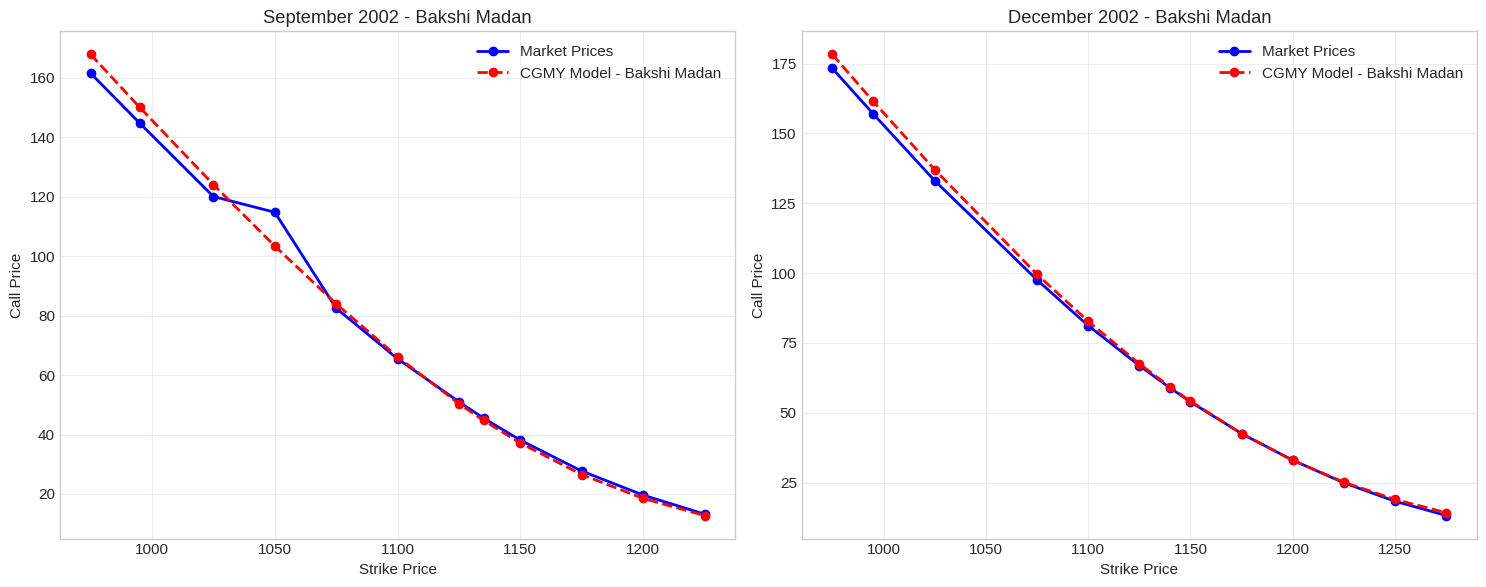

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# September plot
ax1.plot(sept_strikes, sept_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax1.plot(sept_strikes, sept_cgmy_prices, 'ro--', label='CGMY Model - Bakshi Madan', linewidth=2, markersize=6)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price')
ax1.set_title(f'September 2002 - Bakshi Madan')
ax1.legend()
ax1.grid(True, alpha=0.3)

# December plot
ax2.plot(dec_strikes, dec_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax2.plot(dec_strikes, dec_cgmy_prices, 'ro--', label='CGMY Model - Bakshi Madan', linewidth=2, markersize=6)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Call Price')
ax2.set_title(f'December 2002 - Bakshi Madan')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **(ii) - Monte Carlo Simulation for European Option Valuation**

Calculate the same prices as in (i) but using the Monte-Carlo
simulation method for your model and compare prices obtained with the
prices obtained in (i).


In [ ]:
# =============================================================================
# CGMY MONTE CARLO SIMULATION (Schoutens 2003, Chapter 8)
# =============================================================================

def _int_m1Y(a, Y, lo, hi):
    """∫ x^{-1-Y} e^{-a x} dx - for compound-Poisson intensities"""
    hi_eff = min(hi, 40.0/a) if np.isfinite(hi) else 40.0/a
    if hi_eff <= lo: return 0.0
    xs = np.linspace(lo, hi_eff, 25000)
    fx = np.power(xs, -1.0 - Y) * np.exp(-a*xs)
    fx[~np.isfinite(fx)] = 0.0
    return float(max(np.trapz(fx, xs), 0.0))

def _int_1Y(a, Y, lo, hi):
    """∫ x^{1-Y} e^{-a x} dx - for mean jump sizes"""
    lo_eff = max(lo, 1e-12)
    if hi <= lo_eff: return 0.0
    xs = np.linspace(lo_eff, hi, 25000)
    fx = np.power(xs, 1.0 - Y) * np.exp(-a*xs)
    fx[~np.isfinite(fx)] = 0.0
    return float(max(np.trapz(fx, xs), 0.0))

def _build_bins(eps, alpha, K):
    """Build geometric bins for large jumps (Schoutens truncation method)"""
    alpha = max(alpha, (K+1)*eps)
    pos = [eps] + [alpha/i for i in range(K, 0, -1)] + [np.inf]
    neg = [-np.inf] + [-alpha/i for i in range(1, K+1)] + [-eps]
    return np.array(pos), np.array(neg)

def _precompute(C, G, M, Y, eps, alpha, K, clipc):
    """Precompute jump intensities and representative jump sizes"""
    pos, neg = _build_bins(eps, alpha, K)
    lam_p, c_p, lam_n, c_n = [], [], [], []

    # Positive jumps
    for j in range(len(pos)-1):
        A, B = pos[j], pos[j+1]
        lam = C * _int_m1Y(M, Y, A, B)
        m2 = C * _int_1Y(M, Y, A, B)
        ci = 0 if lam <= 1e-16 or m2 <= 0 else np.sqrt(max(m2/lam, 0.0))
        lam_p.append(lam)
        c_p.append(np.clip(ci, 0, clipc))

    # Negative jumps
    for j in range(len(neg)-1):
        A, B = abs(neg[j+1]), abs(neg[j])
        lam = C * _int_m1Y(G, Y, A, B)
        m2 = C * _int_1Y(G, Y, A, B)
        ci = 0 if lam <= 1e-16 or m2 <= 0 else np.sqrt(max(m2/lam, 0.0))
        lam_n.append(lam)
        c_n.append(-np.clip(ci, 0, clipc))

    # Small jump variance
    s2 = C * (_int_1Y(M, Y, 0, eps) + _int_1Y(G, Y, 0, eps))
    return (np.nan_to_num(lam_p), np.nan_to_num(c_p),
            np.nan_to_num(lam_n), np.nan_to_num(c_n), float(max(s2, 0)))

def _sim_XT(T, n_paths, rng, lam_pos, c_pos, lam_neg, c_neg, s2_small):
    """Simulate CGMY log-returns X_T (Schoutens p.190)"""
    XT = np.sqrt(s2_small * T) * rng.standard_normal(n_paths) if s2_small > 0 else np.zeros(n_paths)
    if lam_pos.size: XT += rng.poisson(lam_pos * T, size=(n_paths, lam_pos.size)) @ c_pos
    if lam_neg.size: XT += rng.poisson(lam_neg * T, size=(n_paths, lam_neg.size)) @ c_neg
    return np.nan_to_num(XT)

def _mu(T, C, G, M, Y):
    """Martingale correction (Schoutens eq. 8.7)"""
    return np.exp(T * C * gamma(-Y) * ((M-1)**Y - M**Y + (G+1)**Y - G**Y))

def cgmy_monte_carlo_price(S0, K, T, r, q, C, G, M, Y, lam_pos, c_pos, lam_neg, c_neg, s2_small, rng, n_paths=50000):
    """Monte Carlo pricing for CGMY model"""
    mu_correction = _mu(T, C, G, M, Y)
    XT = _sim_XT(T, n_paths, rng, lam_pos, c_pos, lam_neg, c_neg, s2_small)
    ST = S0 * np.exp((r - q) * T - np.log(mu_correction) + XT)
    payoff = np.maximum(ST[:, None] - K[None, :], 0.0)
    prices = np.exp(-r * T) * payoff.mean(axis=0)
    std_errors = np.exp(-r * T) * payoff.std(axis=0) / np.sqrt(n_paths)
    return prices, std_errors

In [ ]:
# =============================================================================
# CGMY PARAMETERS AND SIMULATION SETUP
# =============================================================================

# Extract strikes and market prices
sept_strikes = []
sept_market = []
dec_strikes = []
dec_market = []

for idx, row in df_options.iterrows():
    strike = row['Strike']
    if pd.notna(row['Sep_2002']):
        sept_strikes.append(strike)
        sept_market.append(row['Sep_2002'])
    if pd.notna(row['Dec_2002']):
        dec_strikes.append(strike)
        dec_market.append(row['Dec_2002'])

sept_strikes = np.array(sept_strikes)
sept_market = np.array(sept_market)
dec_strikes = np.array(dec_strikes)
dec_market = np.array(dec_market)

# CGMY parameters
C, G, M, Y = CGMY_params['C'], CGMY_params['G'], CGMY_params['M'], CGMY_params['Y']

# Numerical parameters for simulation
eps, K_bins, alpha, clipc = 7e-3, 8, 0.35, 20.0

print(f"\nCGMY Parameters:")
print(f" - C = {C}, G = {G}, M = {M}, Y = {Y}")
print(f"\nSimulation parameters:")
print(f" - eps={eps}, K_bins={K_bins}, alpha={alpha}, clipc={clipc}")

# Precompute jump parameters
lam_pos, c_pos, lam_neg, c_neg, s2_small = _precompute(C, G, M, Y, eps, alpha, K_bins, clipc)

print(f"\nJump Simulation Setup:")
print(f" - λ+ per unit time: {lam_pos.sum():.3f}")
print(f" - λ- per unit time: {lam_neg.sum():.3f}")
print(f" - Small jump variance: {s2_small:.6f}")
print(f" - Expected big jumps — Sept: +{lam_pos.sum()*T_sept:.1f} / −{lam_neg.sum()*T_sept:.1f}")
print(f" - Expected big jumps — Dec: +{lam_pos.sum()*T_dec:.1f} / −{lam_neg.sum()*T_dec:.1f}")


CGMY Parameters:
 - C = 0.0244, G = 0.0765, M = 7.5515, Y = 1.2945

Simulation parameters:
 - eps=0.007, K_bins=8, alpha=0.35, clipc=20.0

Jump Simulation Setup:
 - λ+ per unit time: 10.013
 - λ- per unit time: 11.585
 - Small jump variance: 0.002087
 - Expected big jumps — Sept: +4.2 / −4.9
 - Expected big jumps — Dec: +6.7 / −7.8


In [ ]:
# =============================================================================
# MONTE CARLO PRICING
# =============================================================================

print("Calculating Monte Carlo prices...")
print(f"\n>>> Number of paths: 50,000 | Seeds: 7 (Sept), 8 (Dec)")

# Initialize random number generators
rng_sept = np.random.default_rng(7)
rng_dec = np.random.default_rng(8)

# Calculate MC CGMY prices
sept_mc_prices, sept_mc_errors = cgmy_monte_carlo_price(
    S0, sept_strikes, T_sept, r, q, C, G, M, Y, lam_pos, c_pos, lam_neg, c_neg, s2_small, rng_sept)

dec_mc_prices, dec_mc_errors = cgmy_monte_carlo_price(
    S0, dec_strikes, T_dec, r, q, C, G, M, Y, lam_pos, c_pos, lam_neg, c_neg, s2_small, rng_dec)

# Calculate error metrics
ape_sept_mc = calculate_ape(sept_market, sept_mc_prices)
ape_dec_mc = calculate_ape(dec_market, dec_mc_prices)
rmse_sept_mc = calculate_rmse(sept_market, sept_mc_prices)
rmse_dec_mc = calculate_rmse(dec_market, dec_mc_prices)
mae_sept_mc = calculate_mae(sept_market, sept_mc_prices)
mae_dec_mc = calculate_mae(dec_market, dec_mc_prices)
arpe_sept_mc = calculate_arpe(sept_market, sept_mc_prices)
arpe_dec_mc = calculate_arpe(dec_market, dec_mc_prices)

print("\nCGMY Call Option Prices calculated! ✅")

Calculating Monte Carlo prices...

>>> Number of paths: 50,000 | Seeds: 7 (Sept), 8 (Dec)

CGMY Call Option Prices calculated! ✅


In [ ]:
# =============================================================================
# RESULTS TABLE & PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*80)
print("CGMY MODEL - MONTE CARLO SIMULATION RESULTS")
print("="*80)
print(f"Parameters: C={CGMY_params['C']:.4f}, G={CGMY_params['G']:.4f}, "
      f"M={CGMY_params['M']:.4f}, Y={CGMY_params['Y']:.4f}")
print()

# September Results
print("SEPTEMBER 2002 MATURITY - MONTE CARLO vs MARKET PRICES")
print("-" * 75)
print(f"{'Strike':>8} {'Market':>10} {'MC Price':>10} {'Std Error':>12} {'Difference':>12} {'% Error':>10}")
print("-" * 75)

for i, strike in enumerate(sept_strikes):
    market = sept_market[i]
    mc_price = sept_mc_prices[i]
    std_error = sept_mc_errors[i]
    diff = mc_price - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {mc_price:>10.2f} {std_error:>12.4f} {diff:>12.2f} {pct_error:>10.1f}%")

# December Results
print("\nDECEMBER 2002 MATURITY - MONTE CARLO vs MARKET PRICES")
print("-" * 75)
print(f"{'Strike':>8} {'Market':>10} {'MC Price':>10} {'Std Error':>12} {'Difference':>12} {'% Error':>10}")
print("-" * 75)

for i, strike in enumerate(dec_strikes):
    market = dec_market[i]
    mc_price = dec_mc_prices[i]
    std_error = dec_mc_errors[i]
    diff = mc_price - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {mc_price:>10.2f} {std_error:>12.4f} {diff:>12.2f} {pct_error:>10.1f}%")

# Errors
print("\n" + "="*80)
print("MONTE CARLO PERFORMANCE SUMMARY")
print("="*80)
print("ERROR METRICS:")
print(f"  - APE: Average Percentage Error")
print(f"  - MAE: Mean Absolute Error")
print(f"  - RMSE: Root Mean Square Error")
print(f"  - ARPE: Average Relative Percentage Error")
print("\nSEPTEMBER 2002:")
print(f"  - APE:  {ape_sept_mc:.2f}%")
print(f"  - MAE:  {mae_sept_mc:.2f}")
print(f"  - RMSE: {rmse_sept_mc:.2f}")
print(f"  - ARPE: {arpe_sept_mc:.2f}%")
print("\nDECEMBER 2002:")
print(f"  - APE:  {ape_dec_mc:.2f}%")
print(f"  - MAE:  {mae_dec_mc:.2f}")
print(f"  - RMSE: {rmse_dec_mc:.2f}")
print(f"  - ARPE: {arpe_dec_mc:.2f}%")
print("\nOVERALL PERFORMANCE:")
print(f"  - APE:  {(ape_sept_mc + ape_dec_mc) / 2:.2f}%")
print(f"  - MAE:  {(mae_sept_mc + mae_dec_mc) / 2:.2f}")
print(f"  - RMSE: {(rmse_sept_mc + rmse_dec_mc) / 2:.2f}")
print(f"  - ARPE: {(arpe_sept_mc + arpe_dec_mc) / 2:.2f}%")



CGMY MODEL - MONTE CARLO SIMULATION RESULTS
Parameters: C=0.0244, G=0.0765, M=7.5515, Y=1.2945

SEPTEMBER 2002 MATURITY - MONTE CARLO vs MARKET PRICES
---------------------------------------------------------------------------
  Strike     Market   MC Price    Std Error   Difference    % Error
---------------------------------------------------------------------------
   975.0     161.60     174.14       0.4478        12.54        7.8%
   995.0     144.80     155.82       0.4365        11.02        7.6%
  1025.0     120.10     129.14       0.4161         9.04        7.5%
  1050.0     114.80     107.86       0.3956        -6.94       -6.0%
  1075.0      82.50      87.80       0.3715         5.30        6.4%
  1100.0      65.50      69.37       0.3438         3.87        5.9%
  1125.0      51.00      53.04       0.3125         2.04        4.0%
  1135.0      45.50      47.19       0.2992         1.69        3.7%
  1150.0      38.10      39.18       0.2787         1.08        2.8%
  1175.

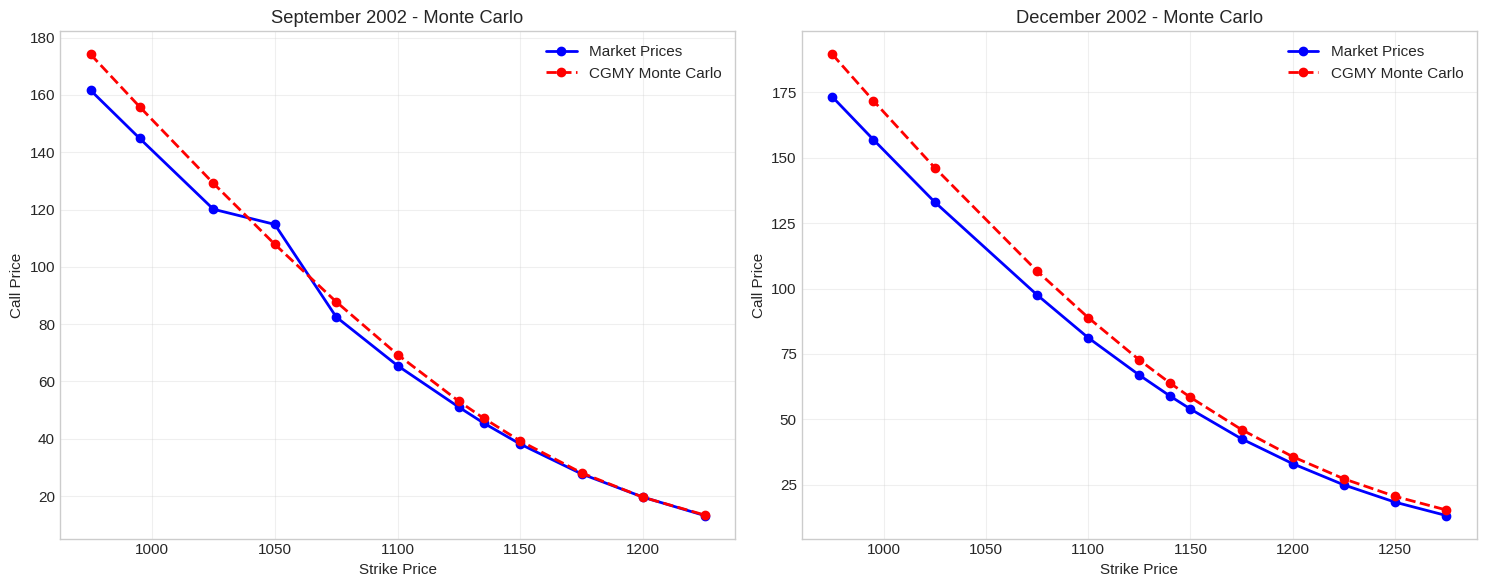

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# September plot
ax1.plot(sept_strikes, sept_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax1.plot(sept_strikes, sept_mc_prices, 'ro--', label='CGMY Monte Carlo', linewidth=2, markersize=6)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price')
ax1.set_title(f'September 2002 - Monte Carlo')
ax1.legend()
ax1.grid(True, alpha=0.3)

# December plot
ax2.plot(dec_strikes, dec_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax2.plot(dec_strikes, dec_mc_prices, 'ro--', label='CGMY Monte Carlo', linewidth=2, markersize=6)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Call Price')
ax2.set_title(f'December 2002 - Monte Carlo')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **(iii) - Calibration and Error Analysis: Comparing CGMY, Black-Scholes, and Market Prices**

Compare the obtained prices obtained in (i) and (ii) with the real
prices (for the strikes in the Table where you have real prices) and
calculate the average percentage error (or average absolute error as a
percentage of the mean price – APE, see book of Schoutens, chapter 1) for
the set of call option prices that you calculated and that are presented in
the Table of appendix C.

Compare this APE value with the APE value obtained by using the Black-Scholes formula (see the parameters estimated for the Black-Scholes model on pages 39-40 in Schoutens book) and the real prices.

In [ ]:
# =============================================================================
# BLACK-SCHOLES PRICING FUNCTION
# =============================================================================

def black_scholes_call_price(S0, K, T, r, q, sigma):
    """
    Calculate Black-Scholes call option price with dividend yield
    C = S₀e^{-qT}N(d₁) - Ke^{-rT}N(d₂)
    """
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return max(0, call_price)

# Black-Scholes parameters from Schoutens pages 39-40
bs_sigma = 0.1812

print("Black-Scholes Parameters:")
print(f" σ = {bs_sigma:.4f}")

Black-Scholes Parameters:
 σ = 0.1812


In [ ]:
# =============================================================================
# BLACK-SCHOLES PRICING
# =============================================================================

print("Calculating Black-Scholes prices...")

# Calculate Black-Scholes prices
sept_bs_prices = [black_scholes_call_price(S0, K, T_sept, r, q, bs_sigma) for K in sept_strikes]
dec_bs_prices = [black_scholes_call_price(S0, K, T_dec, r, q, bs_sigma) for K in dec_strikes]

# Calculate error metrics for Black-Scholes
ape_sept_bs = calculate_ape(np.array(sept_market), np.array(sept_bs_prices))
ape_dec_bs = calculate_ape(np.array(dec_market), np.array(dec_bs_prices))
rmse_sept_bs = calculate_rmse(np.array(sept_market), np.array(sept_bs_prices))
rmse_dec_bs = calculate_rmse(np.array(dec_market), np.array(dec_bs_prices))
mae_sept_bs = calculate_mae(np.array(sept_market), np.array(sept_bs_prices))
mae_dec_bs = calculate_mae(np.array(dec_market), np.array(dec_bs_prices))
arpe_sept_bs = calculate_arpe(np.array(sept_market), np.array(sept_bs_prices))
arpe_dec_bs = calculate_arpe(np.array(dec_market), np.array(dec_bs_prices))

print("\nBlack-Scholes Call Option Prices calculated! ✅")

Calculating Black-Scholes prices...

Black-Scholes Call Option Prices calculated! ✅


In [ ]:
# =============================================================================
# RESULTS TABLE
# =============================================================================

print("\n" + "="*80)
print("BLACK-SCHOLES MODEL - CALL OPTION PRICING RESULTS")
print("="*80)
print(f"Parameters: σ = {bs_sigma:.4f}")
print()

# September Results
print("SEPTEMBER 2002 MATURITY - BLACK-SCHOLES vs MARKET PRICES")
print("-" * 65)
print(f"{'Strike':>8} {'Market':>10} {'BS Price':>10} {'Difference':>12} {'% Error':>10}")
print("-" * 65)

for i, strike in enumerate(sept_strikes):
    market = sept_market[i]
    bs_price = sept_bs_prices[i]
    diff = bs_price - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {bs_price:>10.2f} {diff:>12.2f} {pct_error:>10.1f}%")

# December Results
print("\nDECEMBER 2002 MATURITY - BLACK-SCHOLES vs MARKET PRICES")
print("-" * 65)
print(f"{'Strike':>8} {'Market':>10} {'BS Price':>10} {'Difference':>12} {'% Error':>10}")
print("-" * 65)

for i, strike in enumerate(dec_strikes):
    market = dec_market[i]
    bs_price = dec_bs_prices[i]
    diff = bs_price - market
    pct_error = (diff / market) * 100
    print(f"{strike:>8} {market:>10.2f} {bs_price:>10.2f} {diff:>12.2f} {pct_error:>10.1f}%")

print("\n" + "="*80)
print("BLACK-SCHOLES PERFORMANCE SUMMARY")
print("="*80)
print("ERROR METRICS:")
print(f"  - APE: Average Percentage Error")
print(f"  - MAE: Mean Absolute Error")
print(f"  - RMSE: Root Mean Square Error")
print(f"  - ARPE: Average Relative Percentage Error")
print("\nSEPTEMBER 2002:")
print(f"  - APE:  {ape_sept_bs:.2f}%")
print(f"  - MAE:  {mae_sept_bs:.2f}")
print(f"  - RMSE: {rmse_sept_bs:.2f}")
print(f"  - ARPE: {arpe_sept_bs:.2f}%")
print("\nDECEMBER 2002:")
print(f"  - APE:  {ape_dec_bs:.2f}%")
print(f"  - MAE:  {mae_dec_bs:.2f}")
print(f"  - RMSE: {rmse_dec_bs:.2f}")
print(f"  - ARPE: {arpe_dec_bs:.2f}%")
print("\nOVERALL PERFORMANCE:")
print(f"  - APE:  {(ape_sept_bs + ape_dec_bs) / 2:.2f}%")
print(f"  - MAE:  {(mae_sept_bs + mae_dec_bs) / 2:.2f}")
print(f"  - RMSE: {(rmse_sept_bs + rmse_dec_bs) / 2:.2f}")
print(f"  - ARPE: {(arpe_sept_bs + arpe_dec_bs) / 2:.2f}%")


BLACK-SCHOLES MODEL - CALL OPTION PRICING RESULTS
Parameters: σ = 0.1812

SEPTEMBER 2002 MATURITY - BLACK-SCHOLES vs MARKET PRICES
-----------------------------------------------------------------
  Strike     Market   BS Price   Difference    % Error
-----------------------------------------------------------------
   975.0     161.60     158.01        -3.59       -2.2%
   995.0     144.80     140.92        -3.88       -2.7%
  1025.0     120.10     116.85        -3.25       -2.7%
  1050.0     114.80      98.47       -16.33      -14.2%
  1075.0      82.50      81.80        -0.70       -0.9%
  1100.0      65.50      66.96         1.46        2.2%
  1125.0      51.00      54.00         3.00        5.9%
  1135.0      45.50      49.33         3.83        8.4%
  1150.0      38.10      42.89         4.79       12.6%
  1175.0      27.70      33.56         5.86       21.1%
  1200.0      19.60      25.86         6.26       31.9%
  1225.0      13.20      19.64         6.44       48.8%

DECEMBER

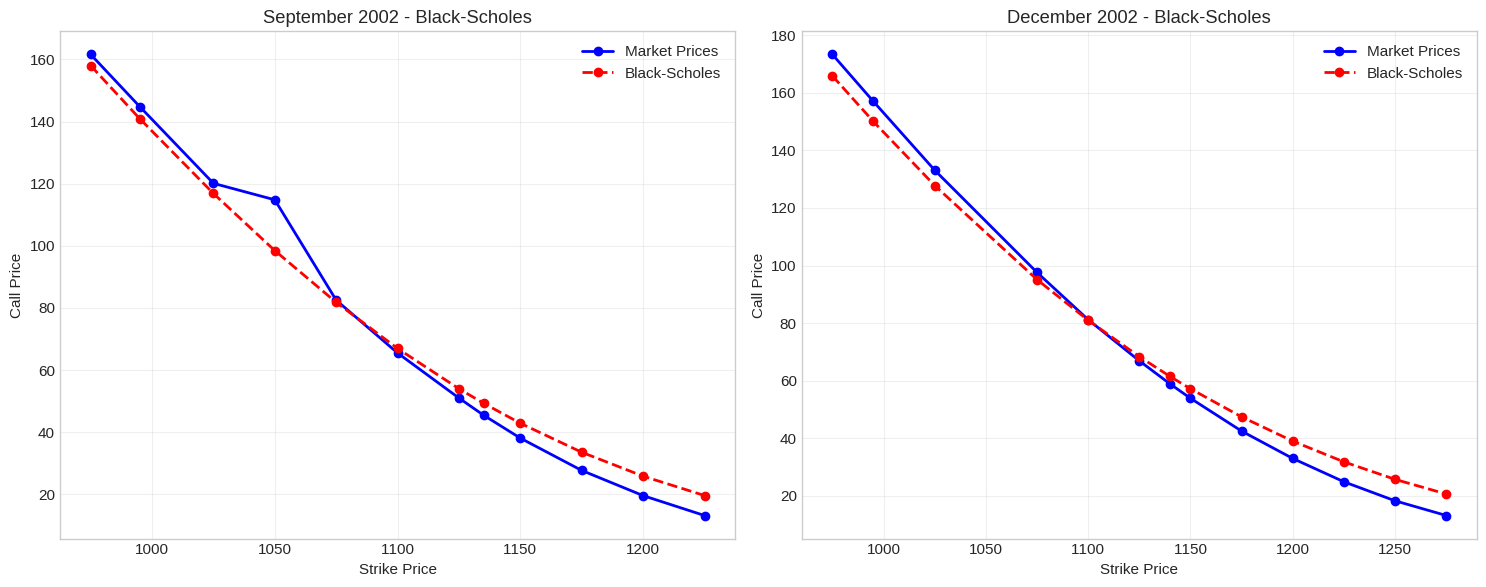

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# September plot
ax1.plot(sept_strikes, sept_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax1.plot(sept_strikes, sept_bs_prices, 'ro--', label='Black-Scholes', linewidth=2, markersize=6)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price')
ax1.set_title(f'September 2002 - Black-Scholes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# December plot
ax2.plot(dec_strikes, dec_market, 'bo-', label='Market Prices', linewidth=2, markersize=6)
ax2.plot(dec_strikes, dec_bs_prices, 'ro--', label='Black-Scholes', linewidth=2, markersize=6)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Call Price')
ax2.set_title(f'December 2002 - Black-Scholes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON: BLACK-SCHOLES vs CGMY BAKSHI-MADAN vs CGMY MONTE CARLO")
print("="*100)

print("\nSEPTEMBER 2002 - ALL MODELS:")
print(f"{'Metric':<8} {'Black-Scholes':<14} {'CGMY Bakshi-Madan':<18} {'CGMY Monte Carlo':<16} {'Best Model':<12}")
print("-" * 85)

# Determine best model for each metric (lowest value)
best_ape_sept = min(ape_sept_bs, ape_sept_bakshi_madan, ape_sept_mc)
best_mae_sept = min(mae_sept_bs, mae_sept_bakshi_madan, mae_sept_mc)
best_rmse_sept = min(rmse_sept_bs, rmse_sept_bakshi_madan, rmse_sept_mc)
best_arpe_sept = min(arpe_sept_bs, arpe_sept_bakshi_madan, arpe_sept_mc)

print(f"{'APE (%)':<8} {ape_sept_bs:<14.2f} {ape_sept_bakshi_madan:<18.2f} {ape_sept_mc:<16.2f} ", end="")
print(f"{'BS' if ape_sept_bs == best_ape_sept else 'Bakshi' if ape_sept_bakshi_madan == best_ape_sept else 'MC'}")

print(f"{'MAE':<8} {mae_sept_bs:<14.2f} {mae_sept_bakshi_madan:<18.2f} {mae_sept_mc:<16.2f} ", end="")
print(f"{'BS' if mae_sept_bs == best_mae_sept else 'Bakshi' if mae_sept_bakshi_madan == best_mae_sept else 'MC'}")

print(f"{'RMSE':<8} {rmse_sept_bs:<14.2f} {rmse_sept_bakshi_madan:<18.2f} {rmse_sept_mc:<16.2f} ", end="")
print(f"{'BS' if rmse_sept_bs == best_rmse_sept else 'Bakshi' if rmse_sept_bakshi_madan == best_rmse_sept else 'MC'}")

print(f"{'ARPE (%)':<8} {arpe_sept_bs:<14.2f} {arpe_sept_bakshi_madan:<18.2f} {arpe_sept_mc:<16.2f} ", end="")
print(f"{'BS' if arpe_sept_bs == best_arpe_sept else 'Bakshi' if arpe_sept_bakshi_madan == best_arpe_sept else 'MC'}")

print("\nDECEMBER 2002 - ALL MODELS:")
print(f"{'Metric':<8} {'Black-Scholes':<14} {'CGMY Bakshi-Madan':<18} {'CGMY Monte Carlo':<16} {'Best Model':<12}")
print("-" * 85)

# Determine best model for each metric (lowest value)
best_ape_dec = min(ape_dec_bs, ape_dec_bakshi_madan, ape_dec_mc)
best_mae_dec = min(mae_dec_bs, mae_dec_bakshi_madan, mae_dec_mc)
best_rmse_dec = min(rmse_dec_bs, rmse_dec_bakshi_madan, rmse_dec_mc)
best_arpe_dec = min(arpe_dec_bs, arpe_dec_bakshi_madan, arpe_dec_mc)

print(f"{'APE (%)':<8} {ape_dec_bs:<14.2f} {ape_dec_bakshi_madan:<18.2f} {ape_dec_mc:<16.2f} ", end="")
print(f"{'BS' if ape_dec_bs == best_ape_dec else 'Bakshi' if ape_dec_bakshi_madan == best_ape_dec else 'MC'}")

print(f"{'MAE':<8} {mae_dec_bs:<14.2f} {mae_dec_bakshi_madan:<18.2f} {mae_dec_mc:<16.2f} ", end="")
print(f"{'BS' if mae_dec_bs == best_mae_dec else 'Bakshi' if mae_dec_bakshi_madan == best_mae_dec else 'MC'}")

print(f"{'RMSE':<8} {rmse_dec_bs:<14.2f} {rmse_dec_bakshi_madan:<18.2f} {rmse_dec_mc:<16.2f} ", end="")
print(f"{'BS' if rmse_dec_bs == best_rmse_dec else 'Bakshi' if rmse_dec_bakshi_madan == best_rmse_dec else 'MC'}")

print(f"{'ARPE (%)':<8} {arpe_dec_bs:<14.2f} {arpe_dec_bakshi_madan:<18.2f} {arpe_dec_mc:<16.2f} ", end="")
print(f"{'BS' if arpe_dec_bs == best_arpe_dec else 'Bakshi' if arpe_dec_bakshi_madan == best_arpe_dec else 'MC'}")

print("\nOVERALL PERFORMANCE - ALL MODELS:")
print(f"{'Metric':<8} {'Black-Scholes':<14} {'CGMY Bakshi-Madan':<18} {'CGMY Monte Carlo':<16} {'Best Model':<12}")
print("-" * 85)

# Calculate overall metrics (average of September and December)
overall_ape_bs = (ape_sept_bs + ape_dec_bs) / 2
overall_ape_bakshi_madan = (ape_sept_bakshi_madan + ape_dec_bakshi_madan) / 2
overall_ape_mc = (ape_sept_mc + ape_dec_mc) / 2

overall_mae_bs = (mae_sept_bs + mae_dec_bs) / 2
overall_mae_bakshi_madan = (mae_sept_bakshi_madan + mae_dec_bakshi_madan) / 2
overall_mae_mc = (mae_sept_mc + mae_dec_mc) / 2

overall_rmse_bs = (rmse_sept_bs + rmse_dec_bs) / 2
overall_rmse_bakshi_madan = (rmse_sept_bakshi_madan + rmse_dec_bakshi_madan) / 2
overall_rmse_mc = (rmse_sept_mc + rmse_dec_mc) / 2

overall_arpe_bs = (arpe_sept_bs + arpe_dec_bs) / 2
overall_arpe_bakshi_madan = (arpe_sept_bakshi_madan + arpe_dec_bakshi_madan) / 2
overall_arpe_mc = (arpe_sept_mc + arpe_dec_mc) / 2

# Determine best overall model
best_overall_ape = min(overall_ape_bs, overall_ape_bakshi_madan, overall_ape_mc)
best_overall_mae = min(overall_mae_bs, overall_mae_bakshi_madan, overall_mae_mc)
best_overall_rmse = min(overall_rmse_bs, overall_rmse_bakshi_madan, overall_rmse_mc)
best_overall_arpe = min(overall_arpe_bs, overall_arpe_bakshi_madan, overall_arpe_mc)

print(f"{'APE (%)':<8} {overall_ape_bs:<14.2f} {overall_ape_bakshi_madan:<18.2f} {overall_ape_mc:<16.2f} ", end="")
print(f"{'BS' if overall_ape_bs == best_overall_ape else 'Bakshi' if overall_ape_bakshi_madan == best_overall_ape else 'MC'}")

print(f"{'MAE':<8} {overall_mae_bs:<14.2f} {overall_mae_bakshi_madan:<18.2f} {overall_mae_mc:<16.2f} ", end="")
print(f"{'BS' if overall_mae_bs == best_overall_mae else 'Bakshi' if overall_mae_bakshi_madan == best_overall_mae else 'MC'}")

print(f"{'RMSE':<8} {overall_rmse_bs:<14.2f} {overall_rmse_bakshi_madan:<18.2f} {overall_rmse_mc:<16.2f} ", end="")
print(f"{'BS' if overall_rmse_bs == best_overall_rmse else 'Bakshi' if overall_rmse_bakshi_madan == best_overall_rmse else 'MC'}")

print(f"{'ARPE (%)':<8} {overall_arpe_bs:<14.2f} {overall_arpe_bakshi_madan:<18.2f} {overall_arpe_mc:<16.2f} ", end="")
print(f"{'BS' if overall_arpe_bs == best_overall_arpe else 'Bakshi' if overall_arpe_bakshi_madan == best_overall_arpe else 'MC'}")

# =============================================================================
# WINNER SUMMARY
# =============================================================================

print("\n" + "="*60)
print("WINNER SUMMARY")
print("="*60)

# Count wins for each model
wins_bs = 0
wins_bakshi = 0
wins_mc = 0

# September wins
if ape_sept_bs == best_ape_sept: wins_bs += 1
elif ape_sept_bakshi_madan == best_ape_sept: wins_bakshi += 1
else: wins_mc += 1

if mae_sept_bs == best_mae_sept: wins_bs += 1
elif mae_sept_bakshi_madan == best_mae_sept: wins_bakshi += 1
else: wins_mc += 1

if rmse_sept_bs == best_rmse_sept: wins_bs += 1
elif rmse_sept_bakshi_madan == best_rmse_sept: wins_bakshi += 1
else: wins_mc += 1

if arpe_sept_bs == best_arpe_sept: wins_bs += 1
elif arpe_sept_bakshi_madan == best_arpe_sept: wins_bakshi += 1
else: wins_mc += 1

# December wins
if ape_dec_bs == best_ape_dec: wins_bs += 1
elif ape_dec_bakshi_madan == best_ape_dec: wins_bakshi += 1
else: wins_mc += 1

if mae_dec_bs == best_mae_dec: wins_bs += 1
elif mae_dec_bakshi_madan == best_mae_dec: wins_bakshi += 1
else: wins_mc += 1

if rmse_dec_bs == best_rmse_dec: wins_bs += 1
elif rmse_dec_bakshi_madan == best_rmse_dec: wins_bakshi += 1
else: wins_mc += 1

if arpe_dec_bs == best_arpe_dec: wins_bs += 1
elif arpe_dec_bakshi_madan == best_arpe_dec: wins_bakshi += 1
else: wins_mc += 1

# Overall wins
if overall_ape_bs == best_overall_ape: wins_bs += 1
elif overall_ape_bakshi_madan == best_overall_ape: wins_bakshi += 1
else: wins_mc += 1

if overall_mae_bs == best_overall_mae: wins_bs += 1
elif overall_mae_bakshi_madan == best_overall_mae: wins_bakshi += 1
else: wins_mc += 1

if overall_rmse_bs == best_overall_rmse: wins_bs += 1
elif overall_rmse_bakshi_madan == best_overall_rmse: wins_bakshi += 1
else: wins_mc += 1

if overall_arpe_bs == best_overall_arpe: wins_bs += 1
elif overall_arpe_bakshi_madan == best_overall_arpe: wins_bakshi += 1
else: wins_mc += 1

print(f"Black-Scholes Wins: {wins_bs}")
print(f"CGMY Bakshi-Madan Wins: {wins_bakshi}")
print(f"CGMY Monte Carlo Wins: {wins_mc}")

if wins_bakshi > wins_bs and wins_bakshi > wins_mc:
    print(f"\n🏆 OVERALL WINNER: CGMY BAKSHI-MADAN METHOD")
elif wins_mc > wins_bs and wins_mc > wins_bakshi:
    print(f"\n🏆 OVERALL WINNER: CGMY MONTE CARLO METHOD")
elif wins_bs > wins_bakshi and wins_bs > wins_mc:
    print(f"\n🏆 OVERALL WINNER: BLACK-SCHOLES METHOD")
else:
    print(f"\n🏆 OVERALL WINNER: TIE")


COMPREHENSIVE MODEL COMPARISON: BLACK-SCHOLES vs CGMY BAKSHI-MADAN vs CGMY MONTE CARLO

SEPTEMBER 2002 - ALL MODELS:
Metric   Black-Scholes  CGMY Bakshi-Madan  CGMY Monte Carlo Best Model  
-------------------------------------------------------------------------------------
APE (%)  6.72           3.87               6.12             Bakshi
MAE      4.95           2.85               4.51             Bakshi
RMSE     6.25           4.29               6.19             Bakshi
ARPE (%) 12.80          3.54               4.57             Bakshi

DECEMBER 2002 - ALL MODELS:
Metric   Black-Scholes  CGMY Bakshi-Madan  CGMY Monte Carlo Best Model  
-------------------------------------------------------------------------------------
APE (%)  6.56           2.11               9.35             Bakshi
MAE      4.81           1.55               6.86             Bakshi
RMSE     5.39           2.31               8.38             Bakshi
ARPE (%) 14.09          2.07               9.76             Bakshi

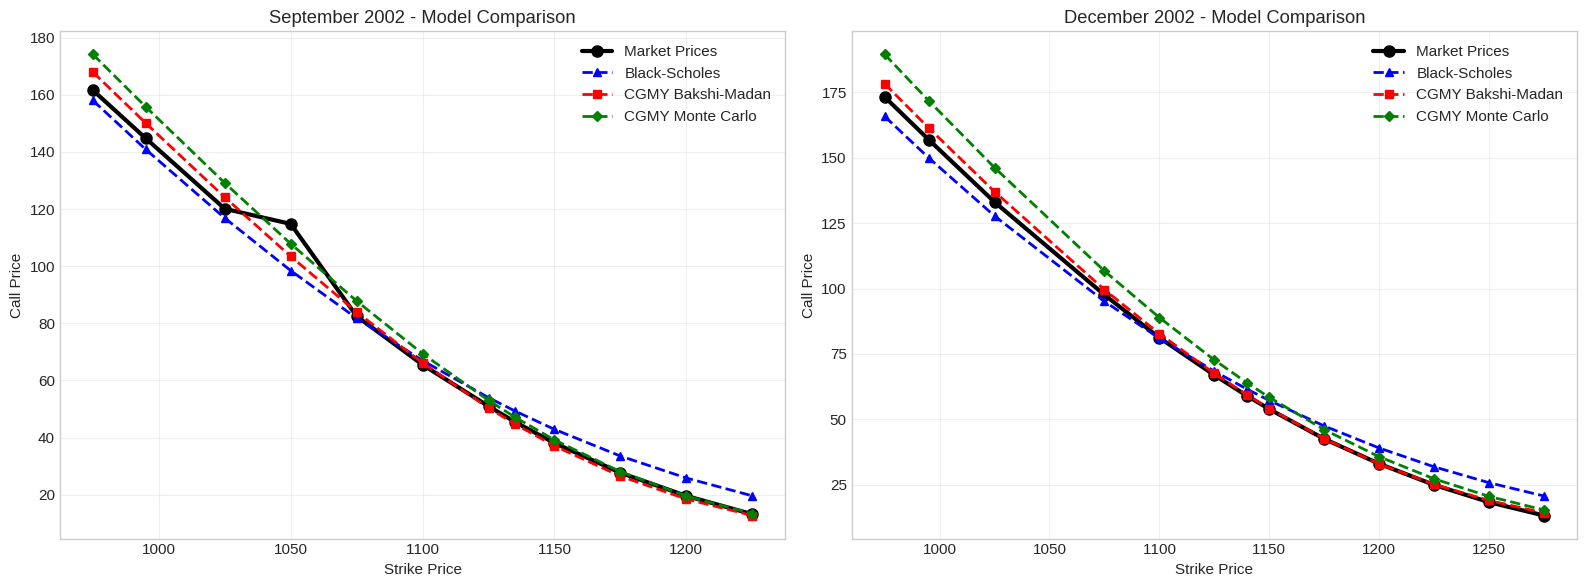

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# September plot - All models
ax1.plot(sept_strikes, sept_market, 'ko-', label='Market Prices', linewidth=3, markersize=8)
ax1.plot(sept_strikes, sept_bs_prices, 'b^--', label='Black-Scholes', linewidth=2, markersize=6)
ax1.plot(sept_strikes, sept_cgmy_prices, 'rs--', label='CGMY Bakshi-Madan', linewidth=2, markersize=6)
ax1.plot(sept_strikes, sept_mc_prices, 'gD--', label='CGMY Monte Carlo', linewidth=2, markersize=5)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price')
ax1.set_title(f'September 2002 - Model Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# December plot - All models
ax2.plot(dec_strikes, dec_market, 'ko-', label='Market Prices', linewidth=3, markersize=8)
ax2.plot(dec_strikes, dec_bs_prices, 'b^--', label='Black-Scholes', linewidth=2, markersize=6)
ax2.plot(dec_strikes, dec_cgmy_prices, 'rs--', label='CGMY Bakshi-Madan', linewidth=2, markersize=6)
ax2.plot(dec_strikes, dec_mc_prices, 'gD--', label='CGMY Monte Carlo', linewidth=2, markersize=5)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Call Price')
ax2.set_title(f'December 2002 - Model Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 3 - Monte Carlo Valuation and Sensitivity Analysis of a Lookback Call Option

By Monte-Carlo simulation, calculate the price of an exotic option of the
type “Lookback Call option” (LC), which gives the right to the holder of the
contract to buy the underlying risky asset by the minimum price it has
achieved over the life of the option (see Schoutens, chapter 9).

Take the time to maturity T to be 1 year and S₀ = 1124.47. Compare the value
obtained with the ones in Table 9.1 (Chapter 9 of Schoutens). You can
consider 3000 simulations of paths and 250 equally small time steps.

Study also the effect on the price of the LC option of changing the maturity
and of changing slightly (about 10%) the value of one estimated parameter
of the model (select the parameter you think can have more influence in
the price).

In [ ]:
'''
The idea lies in simulating the price steps and calculating the price with them.
The simulation of the steps in price uses the methods of section 2.
For that a few parameters need to be set up.
'''

# Market parameters
S0, r, q = 1124.47, 0.019, 0.012

# CGMY parameters from calibration
C, G, M, Y = CGMY_params['C'], CGMY_params['G'], CGMY_params['M'], CGMY_params['Y']

# Precompute jump parameters
lam_pos, c_pos, lam_neg, c_neg, s2_small = _precompute(C, G, M, Y, eps, alpha, K_bins, clipc)

# Simulation parameters
T = 1
n_paths = 3000
n_steps = 250
rng = np.random.default_rng(7)

print("Parameters for Lookback Option Pricing:")
print(f"S0 = {S0}, r = {r}, q = {q}")
print(f"CGMY: C={C:.4f}, G={G:.4f}, M={M:.4f}, Y={Y:.4f}")
print(f"Simulation: {n_paths} paths, {n_steps} time steps")

Parameters for Lookback Option Pricing:
S0 = 1124.47, r = 0.019, q = 0.012
CGMY: C=0.0244, G=0.0765, M=7.5515, Y=1.2945
Simulation: 3000 paths, 250 time steps


In [ ]:
# =============================================================================
# LOOKBACK CALL OPTION PRICING FUNCTIONS
# =============================================================================

def cgmy_get_price(S, T, r, q, C, G, M, Y, lam_pos, c_pos, lam_neg, c_neg, s2_small, rng, n_paths=400):
    """Gets the Monte Carlo price for CGMY model of each step"""
    mu_correction = _mu(T, C, G, M, Y)
    XT = _sim_XT(T, n_paths, rng, lam_pos, c_pos, lam_neg, c_neg, s2_small)
    ST = S * np.exp((r - q) * T - np.log(mu_correction) + XT)
    return ST.reshape(n_paths, 1)

def get_price_history(S0, T, n_paths, n_steps):
    """Stores the price of each step in a np matrix and calculates the payoff for each row"""
    price_history = np.full((n_paths, 1), S0)
    t = 0
    dt = T/n_steps

    for i in range(n_steps):
        t += dt
        price_history = np.append(price_history, cgmy_get_price(
            price_history[:,i], dt, r, q, C, G, M, Y, lam_pos, c_pos, lam_neg, c_neg, s2_small, rng, n_paths), axis=1)

    mc_price = np.maximum(price_history[:, -1] - np.min(price_history[:,:], axis=1), 0)

    return mc_price

### (i) - Calculate Lookback Price (T=1 year)

In [ ]:
print("=" * 60)
print("TASK 1: LOOKBACK CALL OPTION PRICING")
print("=" * 60)

# Run the Monte Carlo simulation
mc_price = get_price_history(S0, T, n_paths, n_steps)
LC_price = np.exp(-r * T) * np.mean(mc_price)
LC_price_se = np.exp(-r * T) * np.std(mc_price) / np.sqrt(n_paths)

print(f"Lookback Call Option Price: {LC_price:.4f}")
print(f"Standard Error: {LC_price_se:.4f}")
print(f"95% Confidence Interval: [{LC_price - 1.96*LC_price_se:.4f}, {LC_price + 1.96*LC_price_se:.4f}]")

TASK 1: LOOKBACK CALL OPTION PRICING
Lookback Call Option Price: 133.8687
Standard Error: 2.0954
95% Confidence Interval: [129.7617, 137.9756]


### (ii) - Comparison with Schoutens Table 9.1

**Table 9.1 Exotic option prices from Schoutens' book**

<br>

| Model | LC |
| :--- | :---: |
| VG-CIR-EWI | 135.27 (0.4942) |
| NIG-CIR-EWI | 135.24 (0.4764) |
| Meixner-CIR-EWI | 135.72 (0.4853) |
| VG-CIR-IILB | 134.77 (0.4894) |
| NIG-CIR-IILB | 135.48 (0.4817) |
| Meixner-CIR-IILB | 134.83 (0.4712) |
| Black-Scholes $\sigma_{\min}$ | 128.64 |
| Black-Scholes $\sigma_{\text{lse}}$ | 155.12 |
| Black-Scholes $\sigma_{\max}$ | 189.76 |

<br>

**Source and Content:**

*These exotic option prices (LC) are reproduced from **Table 9.1** (page 131) of the book: **Lévy Processes in Finance: Pricing Financial Derivatives** by **Wim Schoutens**. These prices serve as benchmark values for comparison with the model prices (VG-CIR, NIG-CIR, Meixner-CIR) presented in the table.*

In [ ]:
print("\n" + "=" * 60)
print("TASK 2: COMPARISON WITH SCHOUTENS TABLE 9.1")
print("=" * 60)

# Reference prices from Schoutens Table 9.1 (price, standard_error)
levy_models = {
    'VG-CIR-EWI': (135.27, 0.4942),
    'NIG-CIR-EWI': (135.24, 0.4764),
    'Meixner-CIR-EWI': (135.72, 0.4853),
    'VG-CIR-IILB': (134.77, 0.4894),
    'NIG-CIR-IILB': (135.48, 0.4817),
    'Meixner-CIR-IILB': (134.83, 0.4712)}

print("SCHOUTENS TABLE 9.1 - LEVY PROCESS MODELS:")
print(f"{'Model':<20} {'Price':<10} {'Std Error':<12}")
print("-" * 45)
for model, (price, se) in levy_models.items():
    print(f"{model:<20} {price:<10.2f} {se:<12.4f}")

# Calculate weighted average of Levy models (weighted by inverse variance)
levy_prices = [price for price, se in levy_models.values()]
levy_se = [se for price, se in levy_models.values()]
levy_mean = np.mean(levy_prices)
levy_se_pooled = np.sqrt(np.mean(np.array(levy_se)**2))  # Pooled standard error

print(f"\nLevy Models Average Price: {levy_mean:.2f}")
print(f"Pooled Standard Error: {levy_se_pooled:.4f}")

print(f"\nOUR CGMY LOOKBACK CALL RESULTS:")
print(f"Price: {LC_price:.2f}")
print(f"Standard Error: {LC_price_se:.4f}")
print(f"95% CI: [{LC_price - 1.96*LC_price_se:.2f}, {LC_price + 1.96*LC_price_se:.2f}]")

# Comparison analysis
print(f"\nCOMPARISON ANALYSIS:")
print(f"Our CGMY vs Levy Models Average: {LC_price - levy_mean:+.2f}")

# Statistical comparison
print(f"\nSTATISTICAL COMPARISON:")
z_score = (LC_price - levy_mean) / np.sqrt(LC_price_se**2 + levy_se_pooled**2)
print(f"Z-score vs Levy average: {z_score:.3f}")

print(f"\nSTANDARD ERROR COMPARISON:")
print(f"Our CGMY SE: {LC_price_se:.4f}")
print(f"Table 9.1 Levy SE range: {min(levy_se):.4f} - {max(levy_se):.4f}")


TASK 2: COMPARISON WITH SCHOUTENS TABLE 9.1
SCHOUTENS TABLE 9.1 - LEVY PROCESS MODELS:
Model                Price      Std Error   
---------------------------------------------
VG-CIR-EWI           135.27     0.4942      
NIG-CIR-EWI          135.24     0.4764      
Meixner-CIR-EWI      135.72     0.4853      
VG-CIR-IILB          134.77     0.4894      
NIG-CIR-IILB         135.48     0.4817      
Meixner-CIR-IILB     134.83     0.4712      

Levy Models Average Price: 135.22
Pooled Standard Error: 0.4831

OUR CGMY LOOKBACK CALL RESULTS:
Price: 133.87
Standard Error: 2.0954
95% CI: [129.76, 137.98]

COMPARISON ANALYSIS:
Our CGMY vs Levy Models Average: -1.35

STATISTICAL COMPARISON:
Z-score vs Levy average: -0.628

STANDARD ERROR COMPARISON:
Our CGMY SE: 2.0954
Table 9.1 Levy SE range: 0.4712 - 0.4942


- Our CGMY price is NOT significantly different from Levy models average (p > 0.05)
- Our CGMY Lookback price is consistent with the Levy process models in Table 9.1.
- Both the price level and Monte Carlo precision are comparable.


In [ ]:
black_scholes_models = {
    'BS (σ_min)': 128.64,
    'BS (σ_lse)': 155.12,
    'BS (σ_max)': 189.76}

print("\nSCHOUTENS TABLE 9.1 - BLACK-SCHOLES MODELS:")
print(f"{'Model':<15} {'Price':<10}")
print("-" * 30)
for model, price in black_scholes_models.items():
    print(f"{model:<15} {price:<10.2f}")

print(f"\nOUR CGMY LOOKBACK CALL RESULTS:")
print(f"Price: {LC_price:.2f}")
print(f"Standard Error: {LC_price_se:.2f}")
print(f"95% CI: [{LC_price - 1.96*LC_price_se:.2f}, {LC_price + 1.96*LC_price_se:.2f}]")

# Comparison analysis
print(f"\nOur CGMY vs Black-Scholes Range:")
print(f"Difference from BS (σ_min): {LC_price - black_scholes_models['BS (σ_min)']:+.2f}")
print(f"Difference from BS (σ_lse): {LC_price - black_scholes_models['BS (σ_lse)']:+.2f}")
print(f"Difference from BS (σ_max): {LC_price - black_scholes_models['BS (σ_max)']:+.2f}")


SCHOUTENS TABLE 9.1 - BLACK-SCHOLES MODELS:
Model           Price     
------------------------------
BS (σ_min)      128.64    
BS (σ_lse)      155.12    
BS (σ_max)      189.76    

OUR CGMY LOOKBACK CALL RESULTS:
Price: 133.87
Standard Error: 2.10
95% CI: [129.76, 137.98]

Our CGMY vs Black-Scholes Range:
Difference from BS (σ_min): +5.23
Difference from BS (σ_lse): -21.25
Difference from BS (σ_max): -55.89


- The Black-Scholes prices show much wider variation, demonstrating the advantage of Levy processes for consistent pricing of path-dependent options.

### (iii) - Maturity Sensivity Analysis

In [ ]:
print("\n" + "=" * 60)
print("TASK 3: MATURITY SENSITIVITY ANALYSIS")
print("=" * 60)

# Trying out different maturities
times = [0.5, 1.0, 1.5, 2.0] # in years
prices = []

print("\nMaturity Effect on Lookback Call Price:\n")
print(f"{'Maturity':<10} {'Price':<25}")
print("-" * 20)

for t in times:
    price = np.mean(np.exp(-r * t) * get_price_history(S0, t, n_paths, n_steps)).item()
    prices.append(price)
    print(f"{t:<10} {price:<25.4f}")

# As seen, the increase in time increases the price of the option
print(f"\nPrice increase from 0.5 to 2.0 years: {prices[-1] - prices[0]:.4f}")
print(f"Percentage increase: {(prices[-1] - prices[0]) / prices[0] * 100:.2f}%")


TASK 3: MATURITY SENSITIVITY ANALYSIS

Maturity Effect on Lookback Call Price:

Maturity   Price                    
--------------------
0.5        86.1756                  
1.0        135.7153                 
1.5        180.9635                 
2.0        220.6624                 

Price increase from 0.5 to 2.0 years: 134.4868
Percentage increase: 156.06%


### (iv) - Parameter Y Sensivity Analysis

Based on the Ansatz's premise that increased volatility should lead to an increase in price, the $Y$ (Fine Structure) parameter was selected as the most influential variable for analysis.

This parameter is directly responsible for controlling the jump activity and overall volatility behavior within the CGMY model.

In [ ]:
print("\n" + "=" * 60)
print("TASK 4: PARAMETER Y SENSITIVITY ANALYSIS")
print("=" * 60)

# Base Y
Y_base = CGMY_params['Y'] # 1.2945

# Increased Y (+10%)
Y_inc = Y_base * 1.1 # 1.4240

# Decreased Y (-10%)
Y_dec = Y_base * 0.9 # 1.1650

print(f"\nBase parameter Y: {Y_base:.4f}")
print(f"Increased Y (+10%): {Y_inc:.4f}")
print(f"Decreased Y (-10%): {Y_dec:.4f}")

# Store original parameters
original_lam_pos, original_c_pos, original_lam_neg, original_c_neg, original_s2_small = (
    lam_pos, c_pos, lam_neg, c_neg, s2_small)

# Calculate price with increased Y
lam_pos_inc, c_pos_inc, lam_neg_inc, c_neg_inc, s2_small_inc = _precompute(
    C, G, M, Y_inc, eps, alpha, K_bins, clipc)

lam_pos, c_pos, lam_neg, c_neg, s2_small = (
    lam_pos_inc, c_pos_inc, lam_neg_inc, c_neg_inc, s2_small_inc)

mc_price_inc = np.mean(np.exp(-r * T) * get_price_history(S0, T, n_paths, n_steps))

# Calculate price with decreased Y
lam_pos_dec, c_pos_dec, lam_neg_dec, c_neg_dec, s2_small_dec = _precompute(
    C, G, M, Y_dec, eps, alpha, K_bins, clipc)

lam_pos, c_pos, lam_neg, c_neg, s2_small = (
    lam_pos_dec, c_pos_dec, lam_neg_dec, c_neg_dec, s2_small_dec)

mc_price_dec = np.mean(np.exp(-r * T) * get_price_history(S0, T, n_paths, n_steps))

# Restore original parameters
lam_pos, c_pos, lam_neg, c_neg, s2_small = (
    original_lam_pos, original_c_pos, original_lam_neg, original_c_neg, original_s2_small)

# Calculate percentage changes
pct_inc = (mc_price_inc - LC_price) / LC_price * 100
pct_dec = (mc_price_dec - LC_price) / LC_price * 100

print("\n\nParameter Y Sensitivity Results:\n")
print(f"{'Parameter Y':<15} {'Value':<10} {'Price':<12} {'Change VS Base':<15} {'% Change':<12}")
print("-" * 65)
print(f"{'Decreased':<15} {Y_dec:<10.4f} {mc_price_dec:<12.4f} {mc_price_dec - LC_price:<15.4f} {pct_dec:+.2f}%")
print(f"{'Base':<15} {Y_base:<10.4f} {LC_price:<12.4f} {'00.0000':<15} {'0.00%':<12}")
print(f"{'Increased':<15} {Y_inc:<10.4f} {mc_price_inc:<12.4f} {mc_price_inc - LC_price:<15.4f} {pct_inc:+.2f}%")


TASK 4: PARAMETER Y SENSITIVITY ANALYSIS

Base parameter Y: 1.2945
Increased Y (+10%): 1.4240
Decreased Y (-10%): 1.1650


Parameter Y Sensitivity Results:

Parameter Y     Value      Price        Change VS Base  % Change    
-----------------------------------------------------------------
Decreased       1.1650     131.8987     -1.9700         -1.47%
Base            1.2945     133.8687     00.0000         0.00%       
Increased       1.4240     147.4695     13.6009         +10.16%


- The output shows that increasing Y increases the price, and decreasing Y decreases the price, confirming Y's significant influence.
- This aligns with the expectation that higher volatility (controlled by Y)
leads to higher option prices due to increased probability of extreme minimum prices.